In [33]:
import pandas as pd
import numpy as np
from deep_translator import GoogleTranslator
from tqdm.notebook import tqdm # Barra de progreso
import matplotlib.pyplot as plt

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [34]:
# 1. Cargar tu dataset original
df_es = pd.read_csv('../data/datos_triaje_limpios.csv')
print(f"🇪🇨 Datos Originales: {len(df_es)} filas")

🇪🇨 Datos Originales: 500 filas


In [35]:
# 2. Cargar el dataset en inglés
try:
    df_en = pd.read_csv('../data/mtsamples.csv')
    print(f"🇺🇸 Datos en Inglés (MTSamples): {len(df_en)} filas")
except FileNotFoundError:
    print("❌ Error: No encontré 'mtsamples.csv' en la carpeta data. Descárgalo de Kaggle.")

🇺🇸 Datos en Inglés (MTSamples): 4999 filas


In [12]:
# Filtramos solo lo que nos sirve para llenar los huecos de tu IA
# Formato: 'Nombre en Inglés': 'TU ETIQUETA EN ESPAÑOL'
df_en['medical_specialty'] = df_en['medical_specialty'].str.strip()

mapeo_categorias = {
    'Orthopedic': 'Traumatología/Muscular',
    'Gastroenterology': 'Gastroenterología/Digestivo',
    'Urology': 'Urología/Renal',
    'Neurology': 'Neurología',
    'Ophthalmology': 'Oftalmología/ORL',
    'Cardiovascular / Pulmonary': 'Cardiología/Circulatorio',
    'Obstetrics / Gynecology' : 'Ginecología/Obstetricia',
    'Hematology - Oncology' : 'Oncología (Tumores)',
    'General Medicine' : 'Síntomas Generales/No clasificados',
    'Allergy / Immunology' : 'Sangre/Inmunología',
    'Bariatrics' : 'Endocrinología/Nutrición',
    'Diets and Nutritions' : 'Endocrinología/Nutrición',
    'Endocrinology' : 'Endocrinología/Nutrición',
    'Chiropractic' : 'Traumatología/Muscular',
    'Dermatology' : 'Dermatología',
    'ENT - Otolaryngology' : 'Oftalmología/ORL',
    'Ophthalmology' : 'Oftalmología/ORL',
    'Nephrology' : 'Urología/Renal',
    'Sleep Medicine' : 'Neurología',
    'Speech - Language' : 'Neurología',
    'Neurosurgery' : 'Neurología',
    'Physical Medicine - Rehab' : 'Traumatología/Muscular',
    'Podiatry' : 'Traumatología/Muscular',
    'Rheumatology' : 'Traumatología/Muscular',
    'Psychiatry / Psychology' : 'Psiquiatría/Mental',
    'Pain Management' : 'Traumatología/Muscular'
}

# Filtramos el dataset inglés
df_en_filtrado = df_en[df_en['medical_specialty'].isin(mapeo_categorias.keys())].copy()

# Asignamos la etiqueta en español
df_en_filtrado['especialidad'] = df_en_filtrado['medical_specialty'].map(mapeo_categorias)

# Nos quedamos con la columna de texto (transcription) y la nueva especialidad
df_en_ready = df_en_filtrado[['transcription', 'especialidad']].dropna()
df_en_ready = df_en_ready.rename(columns={'transcription': 'sintomas'})

print(f"📉 Datos seleccionados para traducir: {len(df_en_ready)} filas")
display(df_en_ready.head(3))

📉 Datos seleccionados para traducir: 2505 filas


,sintomas,especialidad
0,"SUBJECTIVE:, This 23-year-old white female pr...",Sangre/Inmunología
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Endocrinología/Nutrición
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Endocrinología/Nutrición


In [13]:
# Inicializamos el traductor
traductor = GoogleTranslator(source='en', target='es')

def traducir_texto(texto):
    try:
        # Traducimos solo los primeros 400 caracteres para ir rápido y evitar errores de longitud
        # (Los síntomas suelen estar al principio)
        return traductor.translate(texto[:400]) 
    except:
        return np.nan

print("⏳ Iniciando traducción... ve por un café ☕")

# Usamos tqdm para ver una barra de progreso
tqdm.pandas()
df_en_ready['sintomas'] = df_en_ready['sintomas'].progress_apply(traducir_texto)

# Eliminamos errores de traducción
df_en_ready = df_en_ready.dropna()
print("✅ ¡Traducción completada!")
display(df_en_ready.head())

⏳ Iniciando traducción... ve por un café ☕


  0%|          | 0/2505 [00:00<?, ?it/s]

✅ ¡Traducción completada!


,sintomas,especialidad
0,SUBJETIVO: Esta mujer blanca de 23 años se que...,Sangre/Inmunología
1,ANTECEDENTES MÉDICOS ANTERIORES: Tiene dificul...,Endocrinología/Nutrición
2,HISTORIA DE ENFERMEDAD ACTUAL: Hoy he visto AB...,Endocrinología/Nutrición
3,"MODO M 2-D: , ,1. Aumento de tamaño de la aur...",Cardiología/Circulatorio
4,1. El tamaño de la cavidad ventricular izquier...,Cardiología/Circulatorio


In [14]:
print(f"Datos de mtsmaples traducidos a español: {len(df_en_ready)} filas")

Datos de mtsmaples traducidos a español: 2505 filas


In [15]:
df_en_ready.to_csv('../data/datos_triaje_traducidos_mtsamples.csv', index=False) # Sobrescribimos o creamos uno nuevo
print("💾 Guardado en 'data/datos_triaje_traducidos_mtsamples.csv'.")

💾 Guardado en 'data/datos_triaje_traducidos_mtsamples.csv'.


In [36]:
# 1. Unir los dos DataFrames
df_total = pd.concat([df_es, df_en_ready], ignore_index=True)

# 2. Normalizamos las etiquetas (mayúsculas y sin espacios)
df_total['especialidad'] = df_total['especialidad'].str.upper().str.strip()

# 3. Rellenamos los códigos CIE10 faltantes con 'S/C' (Sin Código)
df_total['codigo_cie10'] = df_total['codigo_cie10'].fillna('S/C')

# 4. Mezclar aleatoriamente (Shuffle)
df_total = df_total.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"🚀 DATASET FINAL AUMENTADO: {len(df_total)} filas")
print("Distribución por especialidad:")
print(df_total['especialidad'].value_counts())

🚀 DATASET FINAL AUMENTADO: 3005 filas
Distribución por especialidad:
especialidad
TRAUMATOLOGÍA/MUSCULAR                532
CARDIOLOGÍA/CIRCULATORIO              401
SÍNTOMAS GENERALES/NO CLASIFICADOS    391
NEUROLOGÍA                            355
UROLOGÍA/RENAL                        266
GASTROENTEROLOGÍA/DIGESTIVO           263
OFTALMOLOGÍA/ORL                      218
GINECOLOGÍA/OBSTETRICIA               158
ONCOLOGÍA (TUMORES)                   121
PSIQUIATRÍA/MENTAL                     72
ENDOCRINOLOGÍA/NUTRICIÓN               62
DERMATOLOGÍA                           46
SANGRE/INMUNOLOGÍA                     40
INFECCIOSAS/PARASITARIAS               33
OTROS                                  20
RESPIRATORIO/NEUMOLOGÍA                10
TOXICOLOGÍA/LESIONES                    9
TRAUMATOLOGÍA/LESIONES                  8
Name: count, dtype: int64


In [37]:
df_total.to_csv('../data/datos_triaje_limpios.csv', index=False) # Sobrescribimos o creamos uno nuevo
print("💾 Guardado en 'data/datos_triaje_limpios.csv'.")

💾 Guardado en 'data/datos_triaje_limpios.csv'.


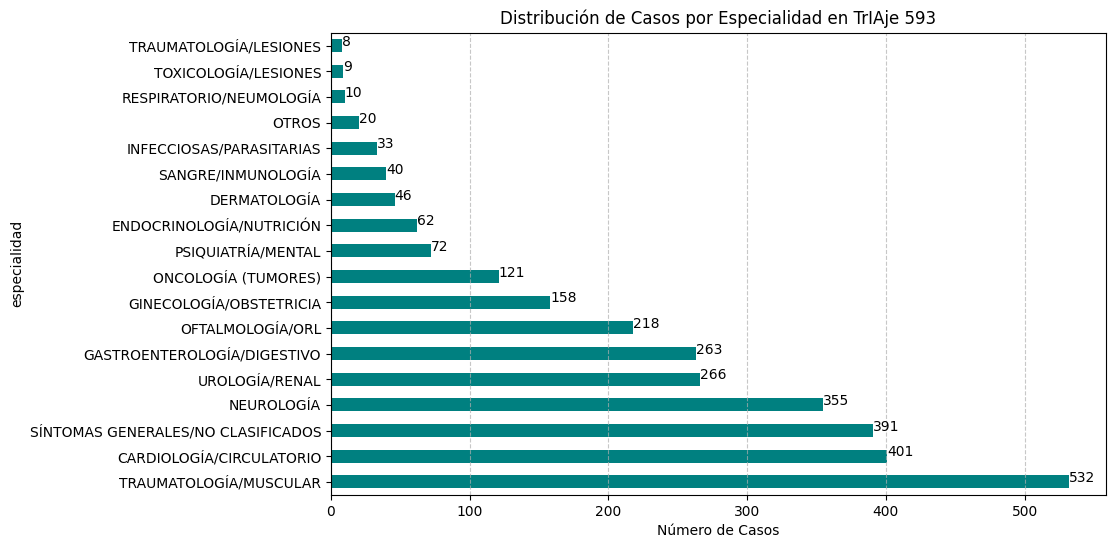

In [38]:
# Ver cuántos casos se tiene por especialidad (Importante para saber si está balanceado)
plt.figure(figsize=(10,6))
df_total['especialidad'].value_counts().plot(kind='barh', color='teal')
plt.title('Distribución de Casos por Especialidad en TrIAje 593')
plt.xlabel('Número de Casos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar los valores en el gráfico
conteo = df_total['especialidad'].value_counts().values
for index, value in enumerate(conteo):
    plt.text(value, index, str(value))

plt.show()

## Los suiguentes bloques se ejecutan solo si hay desbalance de clases (especialidades), sino hay desbalance se ejecuta la celda de guardado de datos procesados.

In [39]:
# ==========================================
# 🔧 CORRECCIÓN DE CLASES (SOLO SI EN LA GRAFICA ANTERIOR SE VE DESBALANCEADO)
# ==========================================

print("Clases originales:", df_total['especialidad'].nunique())

# 1. Función para unificar especialidades confusas
def unificar_categorias(especialidad):
    especialidad = especialidad.upper()
    
    # Fusión de Traumatología (La clave para subir precisión)
    if 'TRAUMATOLOGÍA' in especialidad: 
        return 'TRAUMATOLOGÍA/MUSCULAR'
    
    # Fusión de clases muy pequeñas (< 20 datos) en 'OTROS'
    # Esto evita que el modelo trate de adivinar cosas que no sabe
    elif especialidad in ['RESPIRATORIO/NEUMOLOGÍA', 'TOXICOLOGÍA/LESIONES', 
                          'INFECCIOSAS/PARASITARIAS', 'SANGRE/INMUNOLOGÍA', 'OTROS']:
        return 'SÍNTOMAS GENERALES/NO CLASIFICADOS'
        
    return especialidad

# 2. Aplicar la corrección
df_total['especialidad_corr'] = df_total['especialidad'].apply(unificar_categorias)

# 3. Filtrar la clase 'OTROS' si quieres precisión pura 
# (Opcional: Si dejas 'OTROS', la precisión bajará un poco pero el sistema será más realista. 
#  Para el 80% académico, sugiero sacarla temporalmente o dejarla si son pocos datos).
df = df_total[df_total['especialidad_corr'] != 'SÍNTOMAS GENERALES/NO CLASIFICADOS'] 


print("✅ Nuevas Clases Unificadas:", df['especialidad_corr'].unique())
print("Total de clases ahora:", len(df['especialidad_corr'].unique()))

Clases originales: 18
✅ Nuevas Clases Unificadas: ['UROLOGÍA/RENAL' 'TRAUMATOLOGÍA/MUSCULAR' 'OFTALMOLOGÍA/ORL' 'NEUROLOGÍA'
 'CARDIOLOGÍA/CIRCULATORIO' 'GASTROENTEROLOGÍA/DIGESTIVO'
 'ONCOLOGÍA (TUMORES)' 'PSIQUIATRÍA/MENTAL' 'GINECOLOGÍA/OBSTETRICIA'
 'ENDOCRINOLOGÍA/NUTRICIÓN' 'DERMATOLOGÍA']
Total de clases ahora: 11


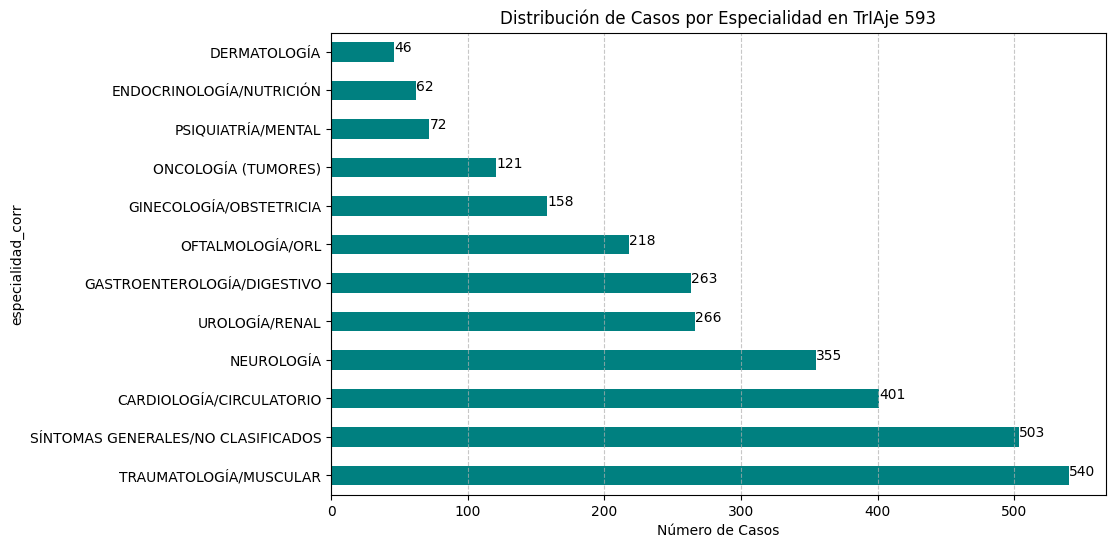

In [40]:
# Ver cuántos casos se tiene por especialidad (Importante para saber si está balanceado)
plt.figure(figsize=(10,6))
df_total['especialidad_corr'].value_counts().plot(kind='barh', color='teal')
plt.title('Distribución de Casos por Especialidad en TrIAje 593')
plt.xlabel('Número de Casos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar los valores en el gráfico
conteo = df_total['especialidad_corr'].value_counts().values
for index, value in enumerate(conteo):
    plt.text(value, index, str(value))

plt.show()

In [41]:
# 3. Guardar como el nuevo archivo maestro
df_total.to_csv('../data/datos_triaje_limpios_2.csv', index=False) # Sobrescribimos o creamos uno nuevo
print("💾 Guardado en 'data/datos_triaje_limpios_2.csv'.")

💾 Guardado en 'data/datos_triaje_limpios_2.csv'.
